In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler 


%matplotlib inline

### Описание

Заказчик - страховая компания, которая предоставила своим клиентам медицинское страхование, и теперь они хотели бы получить модель, чтобы предсказать, будут ли клиенты прошлого года также заинтересованы в страховании транспортных средств, предоставляемом компанией.

### Данные
<ul>
    <li><b>id</b> - Уникальный ID клиента.</li>
    <li><b>Gender</b> - Пол клиента.</li>
    <li><b>Age</b> - Возраст клиента.</li>
    <li><b>DrivingLicense</b> - 0: Клиент не имеет водетельской лицензии, 1: у клиента есть воводительская лицензия.</li>
    <li><b>RegionCode</b> - Уникальный код региона клиента.</li>
    <li><b>Previously_Insured</b> - 1: У клиента уже есть страхование автомоболя, 0: у клиента нет страховки автомобиля.</li>
    <li><b>VehicleAge</b> - Возраст автомобиля.</li> 
    <li><b>VehicleDamage</b> - 1: Транспортное средство клиента попадало в аварии ранее, 0: Транспортное средство клиента не было повреждено ранее</li>
    <li><b>AnnualPremium</b> - Сумма, которую клиент должен заплатить за год.</li>
    <li><b>PolicySalesChannel</b> - Анонимный код для канала связи с клиентов, т.е различные агенты, по почте, по телефону, лично и т.д.</li> 
    <li><b>Vintage</b> - Количество дней, в течение которых клиент был связан с компанией.</li> 
    <li><b>Response</b> - 1: Клиент заинтересован, 0: Клиент не заинтересован.</li> 
</ul>

### Зачада

Построить модель, предсказывающую будет ли клиент заинтересован в использовании услуги в дальнейшем. 

Считывание исходных данных. <b>train.csv</b> - содержит данные для тренировки модели. <b>test.csv</b> - данные для тестирования модели. <b>sample_submission_iA3afxn.csv</b> - файл с ответами клиентов.

Датасет имеет 7 категориальных признака: *Driving_License*, *Gender*, *Policy_Sales_Channel*, *Previously_Insured*, *Region_Code*, *Vehicle_Age*, *Vehicle_Damage*, из которых 3 имеют строковые значения, которые в дальнейшем потребуется преобразовать к числовым.

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submission_iA3afxn.csv")

Распечатаем информацию о первых пяти клиентах.

In [4]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


Выведем информацию о таблицах (имена столбцов, количество ненулевых элементов в каждом  из них, типы элементов в столбцах и т.д). Так же дополнительно проверим наличие повторяющихся строк или строк с пропущенными значениями.

In [5]:
train.info()
test.info()

for df, df_names in (train, 'train'), (test, 'test'):
    print("\n\nThere is {} duplicated values in '{}' data frame".format(df.duplicated().sum(), df_names))
    print("There is {} missing values in '{}' data frame".format(df.isnull().sum().sum(), df_names))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127037 entries, 0 to 127036
Data columns (total 

Визуализация и описательная статистика - важные этапы анализа данных. Сводную информацию о признаках можем получить, вызвав метод *describe*.
Для каждого количественного признака приведены средние значения, стандартное отклонение, минимальное и макимальное значения, медиана и значения квантилей.
По умолчанию этот метод дает информацию только о количественных признаках.

In [6]:
train.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [7]:
test.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage
count,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000
mean,444628.000000,38.765903,0.998134,26.459866,0.460039,30524.643576,111.800468,154.318301
std,36672.567411,15.465814,0.043152,13.209916,0.498403,16945.297103,54.371765,83.661588
min,381110.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000
25%,412869.000000,25.000000,1.000000,15.000000,0.000000,24325.000000,26.000000,82.000000
50%,444628.000000,36.000000,1.000000,28.000000,0.000000,31642.000000,135.000000,154.000000
75%,476387.000000,49.000000,1.000000,35.000000,1.000000,39408.000000,152.000000,227.000000
max,508146.000000,85.000000,1.000000,52.000000,1.000000,472042.000000,163.000000,299.000000


По характеристикам выше можно заметить, что тестовая выборка отражает аналогичные тенденции тренировочной, поэтому изначальное разбиение на них является удовлетворительным и его изменение не требуется.
Прежде чем выполнять графическую отрисовку данных выполним преобразование строчных элементов к числовым. К примеру, мы имеем 2 столбца (Gender, Vehicle_Damage) с булевыми значениями. Заменим эти значениями с помощью 0 и 1. 

In [8]:
print('train[Gender]: ', train['Gender'].unique(), '\ntest[Gender]: ', test['Gender'].unique())
print('train[Vehicle_Damage]: ', train['Vehicle_Damage'].unique(), '\ntest[Vehicle_Damage]: ', test['Vehicle_Damage'].unique())

train[Gender]:  ['Male' 'Female'] 
test[Gender]:  ['Male' 'Female']
train[Vehicle_Damage]:  ['Yes' 'No'] 
test[Vehicle_Damage]:  ['No' 'Yes']


In [9]:
train = train.replace(['Female', 'Male', 'No', 'Yes'], [0, 1, 1, 0])
test = test.replace(['Female', 'Male', 'No', 'Yes'], [0, 1, 1, 0])
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,1,44,1,28.0,0,> 2 Years,0,40454.0,26.0,217,1
1,2,1,76,1,3.0,0,1-2 Year,1,33536.0,26.0,183,0
2,3,1,47,1,28.0,0,> 2 Years,0,38294.0,26.0,27,1
3,4,1,21,1,11.0,1,< 1 Year,1,28619.0,152.0,203,0
4,5,0,29,1,41.0,1,< 1 Year,1,27496.0,152.0,39,0


Столбец *Vehicle_Age* содержит всего 3 уникальных значения. Заменим их на 0,1,2.

In [10]:
print('train[Vehicle_Age]: ', train['Vehicle_Age'].unique())

train[Vehicle_Age]:  ['> 2 Years' '1-2 Year' '< 1 Year']


In [11]:
train = train.replace(['< 1 Year', '1-2 Year', '> 2 Years'], [0, 1, 2])
test = test.replace(['< 1 Year', '1-2 Year', '> 2 Years'], [0, 1, 2])

train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,1,44,1,28.0,0,2,0,40454.0,26.0,217,1
1,2,1,76,1,3.0,0,1,1,33536.0,26.0,183,0
2,3,1,47,1,28.0,0,2,0,38294.0,26.0,27,1
3,4,1,21,1,11.0,1,0,1,28619.0,152.0,203,0
4,5,0,29,1,41.0,1,0,1,27496.0,152.0,39,0


Из рассмотрения также необходимо убрать признак *id*, так как он имеет лишь порядковый характер и никак не влияет на остальные данные.

In [12]:
train=train.drop(columns=['id'], axis=1)
test=test.drop(columns=['id'], axis=1)

print(train.columns)

Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')


Продемонстрируем несбалансированность классов задачи:

0 - 0.91%
1 - 0.09%


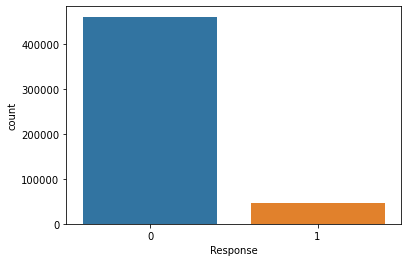

In [13]:
sns.countplot(x=pd.concat([train['Response'], sample['Response']]))
value_counts = (pd.concat([train['Response'], sample['Response']])).value_counts()

total_values = value_counts.values[0] + value_counts.values[1]

print('0 - {:.2f}%'.format(value_counts.values[0] / total_values))
print('1 - {:.2f}%'.format(value_counts.values[1] / total_values))

Дополнительно проанализируем данные *Previously_Insured*,

Доля клиентов, уже имеющих страхование автомобиля -  0.45866739086797886


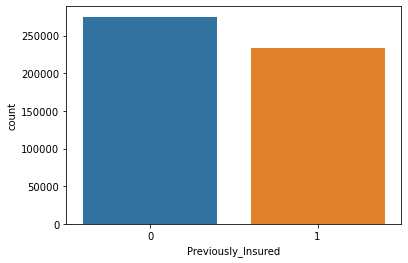

In [14]:
sns.countplot(x=pd.concat([train['Previously_Insured'], test['Previously_Insured']]))
Previously_Insured_data = pd.concat([train['Previously_Insured'], test['Previously_Insured']])

no_ins = Previously_Insured_data.value_counts()[0]            # уже имеют страховку
ins = Previously_Insured_data.value_counts()[1]               # не имеют страхование автомобиля

print('Доля клиентов, уже имеющих страхование автомобиля - ', ins / (ins + no_ins))

Из диаграммы нетрудно видеть, что около 45% клиентов, уже имеют страховку на автомобиль, поэтому, как я считаю, можно предположить, что этот параметр существенно влияет на *Response*. Люди со страховкой вероятнее всего будут отказыватся от предложения. Проверим это:

<AxesSubplot:xlabel='Response', ylabel='count'>

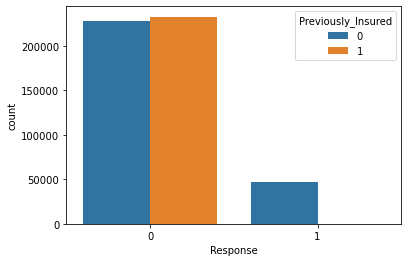

In [15]:
sns.countplot(x=pd.concat([train['Response'], sample['Response']]), hue=pd.concat([train['Previously_Insured'], test['Previously_Insured']]))

Действительно, значительное большинство клиентов имеющих страховку (оранжевый столбик), отказалось от услуги.

Из интересных признаков, которые так же очевидно могут влиять на результат ответа, проанализируем *Driving_License* (наличие водительских прав)

1    507097
0      1049
Name: Driving_License, dtype: int64
Кол-во клиентов имеющих водительские права - 507097.00
Кол-во клиентов не имеющих водительские права - 1049.00


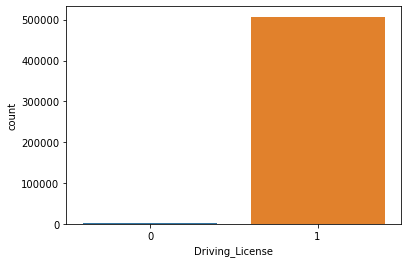

In [16]:
sns.countplot(x=pd.concat([train['Driving_License'], test['Driving_License']]))
value_counts = (pd.concat([train['Driving_License'], test['Driving_License']])).value_counts()
print(value_counts)

print('Кол-во клиентов имеющих водительские права - {:.2f}'.format(value_counts.values[0]))
print('Кол-во клиентов не имеющих водительские права - {:.2f}'.format(value_counts.values[1]))


In [17]:
print(train.loc[:, ['Driving_License', 'Response']][train['Driving_License'] == 0].value_counts())
print(pd.concat([test, sample.loc[:, ['Response']]], axis=1).loc[:, ['Driving_License', 'Response']][test['Driving_License'] == 0].value_counts())

Driving_License  Response
0                0           771
                 1            41
dtype: int64
Driving_License  Response
0                0           237
dtype: int64


Из примера выше можно сделать вывод, что значительное большинство людей, не имеющих водительские права, отказываются от услуги страхования автомобиля.

<AxesSubplot:xlabel='Response', ylabel='count'>

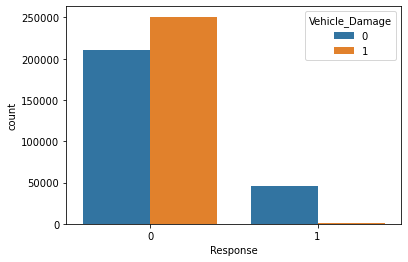

In [18]:
sns.countplot(x=pd.concat([train['Response'], sample['Response']]), hue=pd.concat([train['Vehicle_Damage'], test['Vehicle_Damage']]))

Интересным наблюдением является то, что большинство клиентов, чье транспортное средство ранее не попадало в аварии (оранжевый столбик) ответило отрицательно на предложение приобретения автомобильной страховки. 

In [19]:
np.random.seed(42)
random_subset = np.random.choice(np.arange(train.shape[0]), size=1000, replace=False)

Отрисовка всех точек требует много времени. Тем более, точки накладываются друг на друга и сложно понять сколько точек на том или ином участке графика (особенно, если не использовать параметр alpha). Поэтому изобразим только  1000  случайных точек:

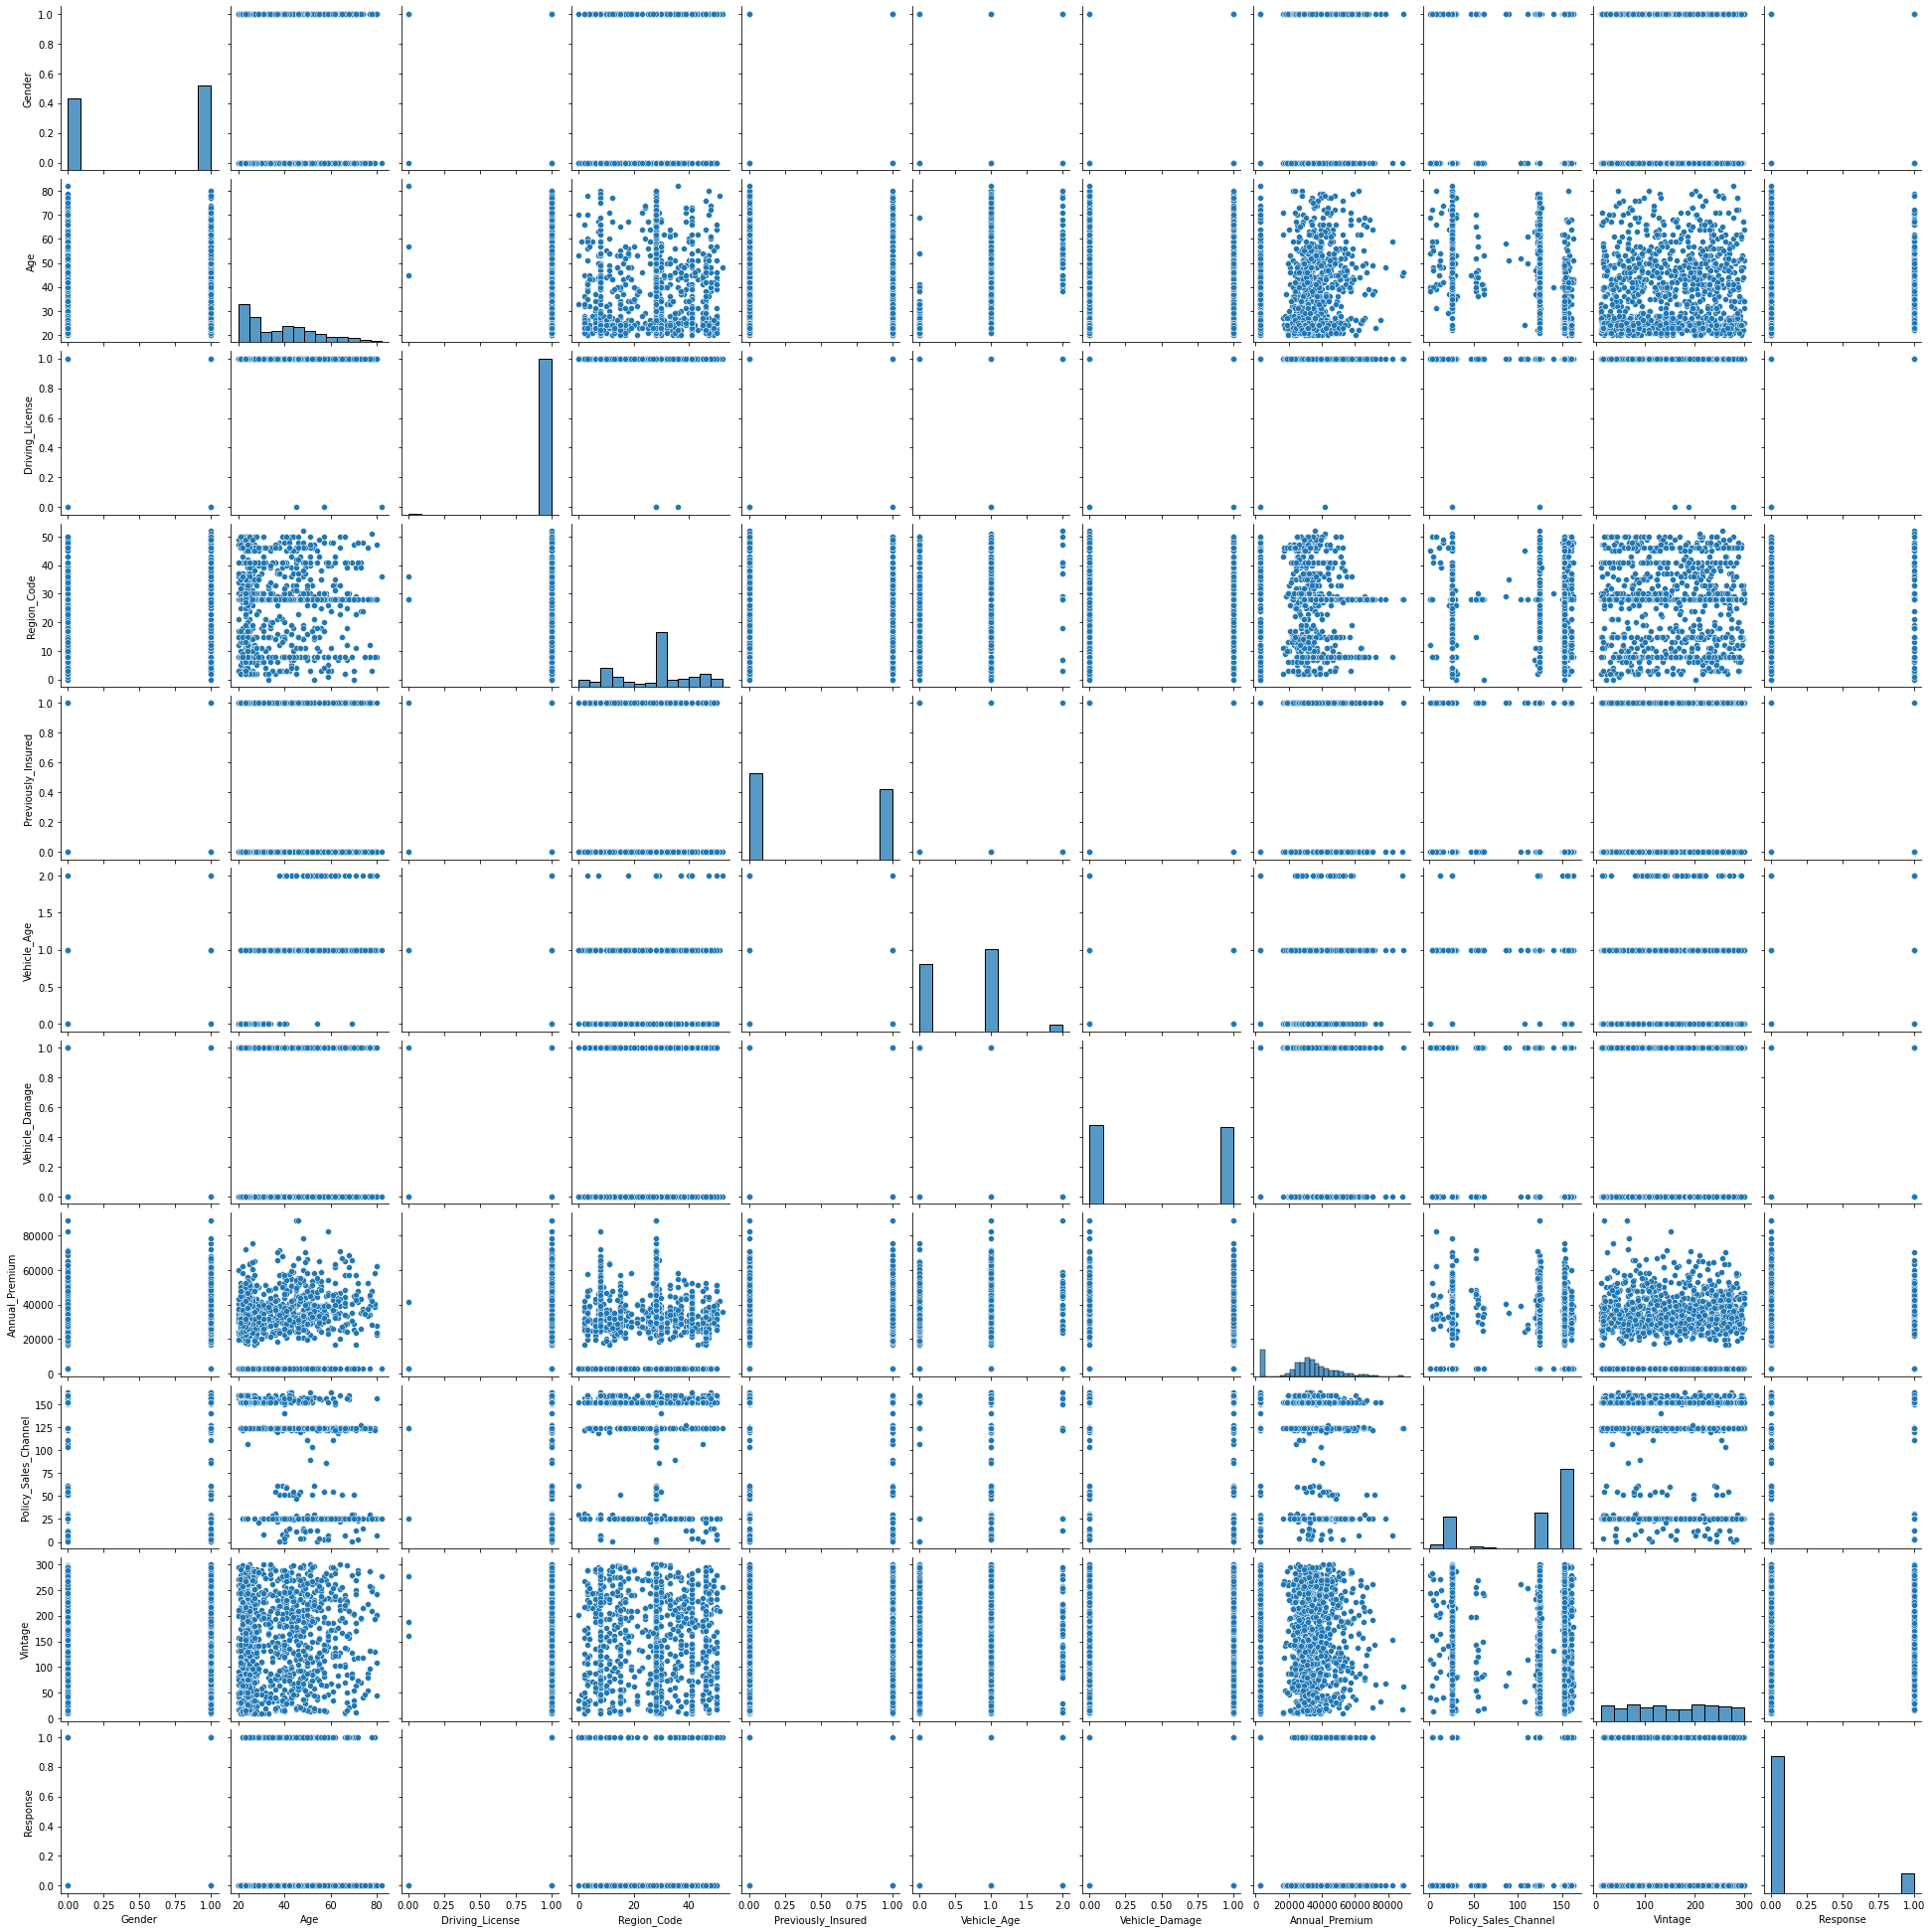

In [20]:
sns.pairplot(train.iloc[random_subset], diag_kind='hist')

По данным графикам нельзя уверенно сказать что нет никаких зависимостей между признаками. Бинарные признаки не инфомативны на них, поэтому воспользуемся корреляционной матрницей.

<AxesSubplot:>

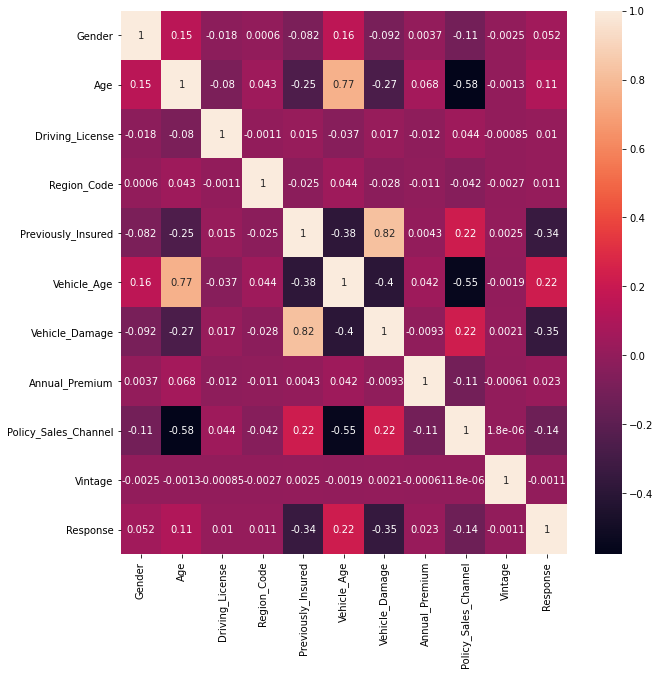

In [21]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(),annot=True)

На основе матрицы корреляция мы убедились в размышлениях, описанных выше. Действительно, наличие страховки и попадание транспортного средства в аварию имеют наибольшую корреляцию с признаком, характеризующим ответ на предложение услуги.
Так как доля опрошенных людей не имеющих водительских прав очень мала, их корреляция была оценена практически нулевой. 
Среди остальных признаков больше нельзя выделить тех, которые так или иначе имеют связь с целевым признаком *Response*

In [22]:
test.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,1,25,1,11.0,1,0,1,35786.0,152.0,53
1,1,40,1,28.0,0,1,0,33762.0,7.0,111
2,1,47,1,28.0,0,1,0,40050.0,124.0,199
3,1,24,1,27.0,1,0,0,37356.0,152.0,187
4,1,27,1,28.0,1,0,1,59097.0,152.0,297


### Обучение

In [24]:
X_train = train.drop('Response', axis = 1)
Y_train = train['Response']

X_test = test
Y_test = sample['Response']

In [25]:
knn_errs_test = list()
knn_errs_train = list()

for i in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, Y_train)
    
    y_test_predict = knn.predict(X_test)
    y_train_predict = knn.predict(X_train)
    
    err_test  = np.mean(Y_test  != y_test_predict)
    err_train  = np.mean(Y_train  != y_train_predict)
    
    knn_errs_test.append(err_test)
    knn_errs_train.append(err_train)
    
    print("# Neighbors: ", i, " | Error train: ", err_train, " | Error test: ", err_test)

# Neighbors:  1  | Error train:  0.0001390678257401426  | Error test:  0.12578225241465085
# Neighbors:  2  | Error train:  0.0989008393924048  | Error test:  0.023528578288215245
# Neighbors:  3  | Error train:  0.09964078518219197  | Error test:  0.06062013429158434
# Neighbors:  4  | Error train:  0.11433212020707986  | Error test:  0.016200004723033446
# Neighbors:  5  | Error train:  0.11469159741701193  | Error test:  0.03326589891134079
# Neighbors:  6  | Error train:  0.1186012400651782  | Error test:  0.010516621141872053
# Neighbors:  7  | Error train:  0.11870094907231264  | Error test:  0.01989184253406488
# Neighbors:  8  | Error train:  0.12067676176631882  | Error test:  0.006911372277368011
# Neighbors:  9  | Error train:  0.12053244609809792  | Error test:  0.012429449687886207
# Neighbors:  10  | Error train:  0.12148755342959626  | Error test:  0.004195628045372608
# Neighbors:  11  | Error train:  0.12163186909781716  | Error test:  0.007470264568590253
# Neighbors:

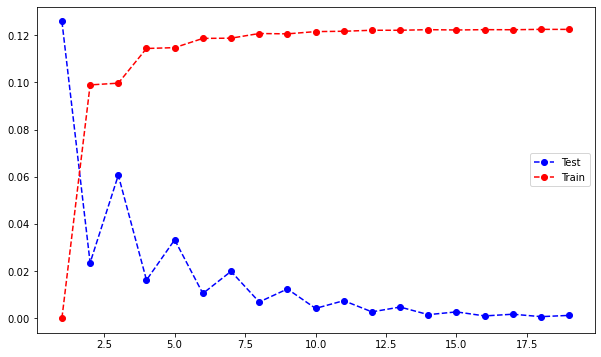

In [26]:
plt.figure(figsize=(10,6))
plt.plot(range(1,20), knn_errs_test, color = "blue", linestyle = "dashed", marker = 'o', label='Test')
plt.plot(range(1,20), knn_errs_train, color = "red", linestyle = "dashed", marker = 'o', label='Train')
plt.legend()

### Обучение с нормированными данными

Проведем нормализацию данных и сравним полученные результаты.

In [27]:
for colums in ['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']:
    X_train[[colums]] = (X_train[[colums]] - X_train[[colums]].mean(axis = 0))/X_train[[colums]].std(axis = 0)
    X_test[[colums]] = (X_test[[colums]] - X_test[[colums]].mean(axis = 0))/X_test[[colums]].std(axis = 0)

In [28]:
knn_errs_test = list()
knn_errs_train = list()

for i in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, Y_train)
    
    y_test_predict = knn.predict(X_test)
    y_train_predict = knn.predict(X_train)
    
    err_test  = np.mean(Y_test  != y_test_predict)
    err_train  = np.mean(Y_train  != y_train_predict)
    
    knn_errs_test.append(err_test)
    knn_errs_train.append(err_train)
    
    print("# Neighbors: ", i, " | Error train: ", err_train, " | Error test: ", err_test)

# Neighbors:  1  | Error train:  0.00014169174698052263  | Error test:  0.12257846139313744
# Neighbors:  2  | Error train:  0.08663400759362808  | Error test:  0.035918669364043546
# Neighbors:  3  | Error train:  0.08672059699456061  | Error test:  0.0845580421452018
# Neighbors:  4  | Error train:  0.1033457619736086  | Error test:  0.034391555216196856
# Neighbors:  5  | Error train:  0.103162087486782  | Error test:  0.06490235128348434
# Neighbors:  6  | Error train:  0.1103411360004618  | Error test:  0.03152624825838141
# Neighbors:  7  | Error train:  0.10981372783114542  | Error test:  0.05252013193006762
# Neighbors:  8  | Error train:  0.11384669477760956  | Error test:  0.02696064925966451
# Neighbors:  9  | Error train:  0.11383357517140766  | Error test:  0.042798554751765236
# Neighbors:  10  | Error train:  0.11605603646200956  | Error test:  0.023977266465675353
# Neighbors:  11  | Error train:  0.11596682313983664  | Error test:  0.03658776576902792
# Neighbors:  12 

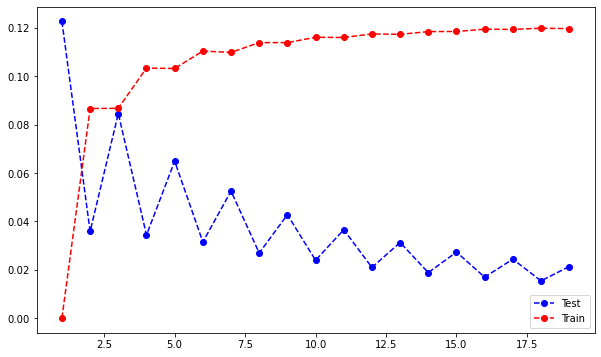

In [29]:
plt.figure(figsize=(10,6))
plt.plot(range(1,20), knn_errs_test, color = "blue", linestyle = "dashed", marker = 'o', label='Test')
plt.plot(range(1,20), knn_errs_train, color = "red", linestyle = "dashed", marker = 'o', label='Train')
plt.legend()

Из полученных данных можно заметить, что поведение линии ошибок на тестовой выборке для обоих типов данных (исходных и нормированных) идентично и представляет волнообразную кривую, где меньшая ошибка соответствует четному числу соседей. Однако исходные данные гораздо быстрее приходят к минимальной ошибке. Уже начиная с 10 соседей ошибка составляет всего лишь ~0.004